# Federate Learning for Image Classification

*The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.*

In this tutorial, we will use the image classification task to show how to complete the horizontal federated learning task in the `SecretFlow` framework.
The `SecretFlow` framework provides a user-friendly API that makes it easy to apply your Keras or PyTorch model to a federated learning scenario as a federated learning model.
In the rest of the tutorial we will show you how to turn your existing model into a federated model in `SecretFlow` to complete federated multi-party modeling tasks

## What is Federate Learning

The federated learning here refers specifically to the federated learning of horizontal scenarios. This mode applies to the situation where each participant has the same business but different customer groups are reached. In this case, samples from various parties can be combined to train a joint model with better performance. For example, in the medical scene, each hospital has its own unique patient group, and hospitals in different regions almost do not overlap each other, but their examination records for medical records (such as images, blood tests, etc.) are of the same type.

<img alt="split_learning_tutorial.png" src="resource/federate_learning.png" width="600">

Training process:
1. Each participant downloads the latest model from the server.
2. Each participant uses its own local data to train the model, and uploads gradient encryption (or parameter encryption) to the server, which obtains the encryption gradient (encryption parameter) uploaded by all parties for security aggregation at the server, and updates model parameters with the aggregated gradient.
3. The server returns the updated model to each participant.
4. Each participant updates their local model, and prepare next training.

## Federate learning on SecretFlow

In [1]:
%load_ext autoreload
%autoreload 2

Create 3 entities in the Secretflow environment [Alice, Bob, Charlie]
Alice, Bob and Charlie are the three PYUs.
Alice and Bob to be the clients and Charlie to be the server

In [2]:
import secretflow as sf

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], num_cpus=8, log_to_driver=True)
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

2022-06-29 11:12:30.841754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib


In [3]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

### Prepare Data

In [4]:
from secretflow.data.ndarray import load
from secretflow.data.simulation.dataset import load_mnist_data
data_split = {
            alice: 0.5,
            bob: 1.0,
        }
train_data_dict, test_data_dict = load_mnist_data(party_ratio=data_split)
train_npz = load(train_data_dict, allow_pickle=True)

(pid=1657322) 2022-06-29 11:12:36.962363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
(pid=1657325) 2022-06-29 11:12:36.962363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
(SPURuntime 

Fed_npz is a dictionary from which image and label are the FedNdarray required for federated training later

In [5]:
train_image = train_npz['image']
train_label = train_npz['label']

Let's take a look at the data obtained from FedNdarray. FedNdarray is a virtual Ndarray built on a multi-party concept to protect data privacy.
The underlying data is stored in each participant. The FedNdarray operation is actually performed by each participant on their own local data. The server or other clients do not touch the original data.
For demonstration purposes, we will manually download the data to the driver
**This data will be used later in the unilateral model comparison**

In [6]:
import requests
import io
import numpy as np

dataset_dict = {}
for device, url in train_data_dict.items():
    dataset_dict[device] = np.load(url)

In [7]:
alice_data,alice_label = dataset_dict[alice]["image"],dataset_dict[alice]["label"]
bob_data, bob_label = dataset_dict[bob]["image"], dataset_dict[bob]["label"]

Let's grab some samples from the data set, and just visually see, what does the data look like for Both Alice and Bob?

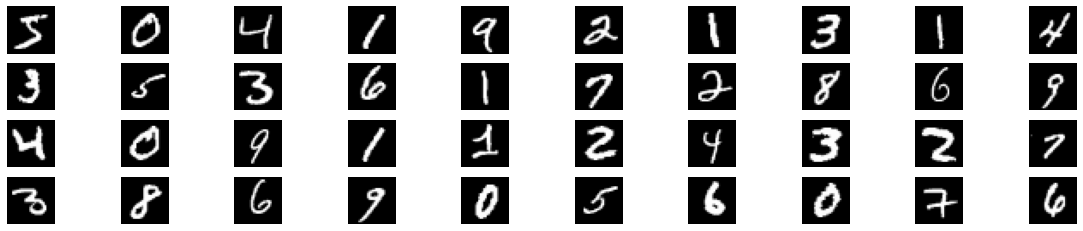

In [8]:
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(20, 4))
j = 0

for example in alice_data[:40]:
  plt.subplot(4, 10, j+1)
  plt.imshow(example, cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

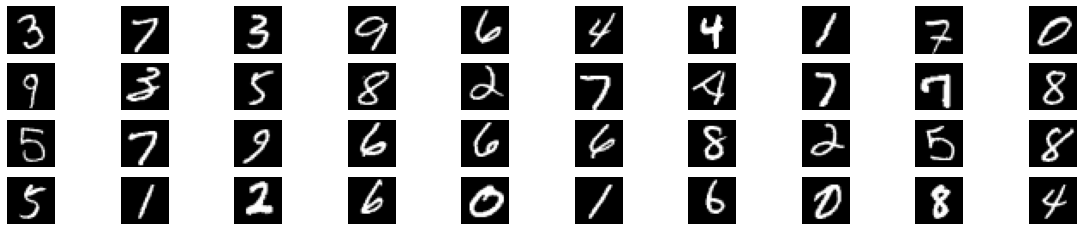

In [9]:
figure = plt.figure(figsize=(20, 4))
j = 0
for example in bob_data[:40]:
  plt.subplot(4, 10, j+1)
  plt.imshow(example, cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

It can be seen from the above two examples that the data types and tasks of Alice and Bob are consistent, but the samples are different due to the different user groups they reach.

Let's take the FedNdarray again, and prepare the test set

In [10]:
test_npz = load(test_data_dict, allow_pickle=True)
test_image = test_npz['image']
test_label = test_npz['label']

(_run pid=1657324) 2022-06-29 11:12:53.613520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib


### Define Model

In [11]:
def create_conv_model(input_shape, num_classes, name='model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers
        # Create model
        model = keras.Sequential(
            [
                keras.Input(shape=input_shape),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )
        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=["accuracy"])
        return model

    return create_model


### Training FL Model

1. Import packages

In [12]:
from secretflow.security.aggregation import SpuAggregator, SecureAggregator
from secretflow.ml.nn import FLModelTF

2. Define Model

In [13]:
num_classes = 10
input_shape = (28, 28, 1)
model = create_conv_model(input_shape, num_classes)

3. Define the device list for participating training, which is the PYUS of each participant prepared previously

In [14]:
device_list = [alice, bob]

4. Define Aggregator  
 Secretflow offer a variety of aggregation schemes, `PlainAggregator` corresponding plaintext aggregation，`SecureAggregator` and `SPUAggregator`can be used security aggregation, more information about aggregation,see [Secure Aggregator](./Secure_aggregation.ipynb).

In [15]:
secure_aggregator = SecureAggregator(charlie, [alice, bob])
spu_aggregator = SpuAggregator(spu)

(_run pid=1657328) 2022-06-29 11:13:03.007251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib


5. Define `FLModelTF`

In [16]:
fed_model = FLModelTF(
            device_list=device_list, model=model, aggregator=secure_aggregator)

(PYUTFModel pid=1657324) 2022-06-29 11:13:06.432268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
(PYUTFModel pid=1657324) 2022-06-29 11:13:06.432298: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
(_run pid=1657320) 2022-06-29 11:13:06.551059: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtools

6. Lets run model

In [17]:
history = fed_model.fit(train_image, train_label, validation_data=(test_image,test_label), epochs=20, batch_size=128, aggregate_freq=1)

 16%|█▌        | 38/235 [00:00<00:02, 79.57it/s](PYUTFModel pid=1657320) 2022-06-29 11:13:08.724918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
(PYUTFModel pid=1657320) 2022-06-29 11:13:08.724944: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
 97%|█████████▋| 227/235 [00:02<00:00, 81.86it/s]

(_run pid=1657326) 


2022-06-29 11:13:23.360703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib:/opt/rh/devtoolset-10/root/usr/lib64/dyninst:/opt/rh/devtoolset-10/root/usr/lib/dyninst:/opt/rh/devtoolset-10/root/usr/lib64:/opt/rh/devtoolset-10/root/usr/lib
2022-06-29 11:13:23.360735: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
100%|██████████| 235/235 [00:13<00:00, 18.04it/s, epoch: 19/20 -  loss:0.036405596882104874  accuracy:0.988676905632019  val_loss:0.013037629425525665  val_accuracy:0.9950000047683716 ]


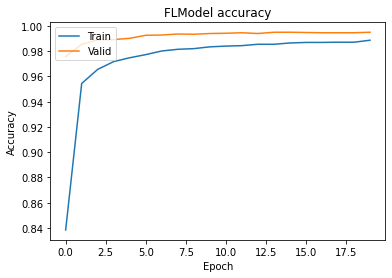

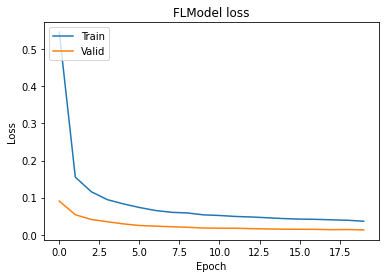

In [18]:
# Draw accuracy values for training & validation
plt.plot(history.global_history['accuracy'])
plt.plot(history.global_history['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history.global_history['loss'])
plt.plot(history.global_history['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [19]:
global_metric = fed_model.evaluate(test_image, test_label, batch_size=128)
print(global_metric)

([Mean(name='loss', total=65.18815, count=5000.0), Mean(name='accuracy', total=4975.0, count=5000.0)], {'alice': [Mean(name='loss', total=0.0, count=0.0), Mean(name='accuracy', total=0.0, count=0.0)], 'bob': [Mean(name='loss', total=65.18815, count=5000.0), Mean(name='accuracy', total=4975.0, count=5000.0)]})


### Contrast experiment to local training

#### Model
The model structure is consistent with the fl model above
#### Data
Here, we only used data after a horizontal segmentation, with a total of 20,000 samples for `Alice`

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split

def create_model():

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

single_model = create_model()

In [21]:
from sklearn.model_selection import train_test_split
random_seed = 1234
X_train, X_test, y_train, y_test = train_test_split(alice_data, alice_label, test_size=0.33, random_state=random_seed)

In [22]:
single_model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=128,epochs=10)

Epoch 1/10
158/158 [==============================] - 3s 14ms/step - loss: 0.6568 - accuracy: 0.8012 - val_loss: 0.1853 - val_accuracy: 0.9462
Epoch 2/10
158/158 [==============================] - 2s 12ms/step - loss: 0.1964 - accuracy: 0.9390 - val_loss: 0.1224 - val_accuracy: 0.9658
Epoch 3/10
158/158 [==============================] - 2s 12ms/step - loss: 0.1404 - accuracy: 0.9571 - val_loss: 0.0984 - val_accuracy: 0.9728
Epoch 4/10
158/158 [==============================] - 2s 13ms/step - loss: 0.1162 - accuracy: 0.9656 - val_loss: 0.0818 - val_accuracy: 0.9765
Epoch 5/10
158/158 [==============================] - 2s 13ms/step - loss: 0.1025 - accuracy: 0.9696 - val_loss: 0.0710 - val_accuracy: 0.9784
Epoch 6/10
158/158 [==============================] - 2s 13ms/step - loss: 0.0868 - accuracy: 0.9729 - val_loss: 0.0631 - val_accuracy: 0.9809
Epoch 7/10
158/158 [==============================] - 2s 12ms/step - loss: 0.0787 - accuracy: 0.9770 - val_loss: 0.0607 - val_accuracy: 0.9816

The two experiments above simulated a training problem in a typical horizontal federation scenario,
* Alice and Bob have same type of data
* Each side had only a portion of the sample, but the training objectives is the same 
If Alice only uses her own data to train the model, could only obtain a model with an accuracy of 0.981. However, if Bob's data is combined, a model with an accuracy close to 0.995 can be obtained. In addition, the generalization performance of the model jointly trained with multi-party data will also be better

## Conclusion
* This tutorial introduces what federated learning is and how to perform horizontal federated learning in `secretFlow`  
* It can be seen from the experimental data that horizontal federation can improve the model effect by expanding the sample size and combining multi-party training.
* This tutorial uses a SecureAggregator to demonstrate, and secretflow provides a variety of aggregation schemes，for more infomation, see[Secure Aggregation](./Secure_aggregation.ipynb).
* next, you can use your data or model to explore how to do federate learning
